<a href="https://colab.research.google.com/github/ksee1230/NL_team12/blob/master/%EC%9E%90%EC%97%B0%EC%96%B4%EC%B2%98%EB%A6%AC_NSMC_12%EC%A1%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

konlpy 설치 및 필요 모듈 import

In [ ]:
!apt-get update
!apt-get install g++ openjdk-8-jdk 
!pip3 install konlpy

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

데이터 로드

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/ksee1230/NL_team12/master/ko_data.csv", filename="ratings_test.csv")

train_data = pd.read_table('ratings.txt')
test_data = pd.read_csv('ratings_test.csv', encoding = 'utf-8')

데이터 로드 후 data 확인

In [ ]:
print('훈련용 리뷰 개수:',len(train_data))
train_data[:5]

In [ ]:
print('테스트용 리뷰 개수:', len(test_data))
test_data[:5]

# 데이터 정제

(1) 중복 데이터 제거

In [6]:
train_data['document'].nunique()
train_data.drop_duplicates(subset=['document'], inplace=True) # document 열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 194544


In [9]:
print(train_data.isnull().values.any())

True


In [10]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) # Null 값이 존재하는지 확인

False


(2) 정규 표현식을 통해 한글과 공백을 제외한 모든 데이터 제거

In [ ]:
train_data['document'] = train_data['document'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
# 한글과 공백을 제외하고 모두 제거
train_data[:5]

In [ ]:
train_data['document'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

In [14]:
train_data = train_data.dropna(how = 'any')
print(len(train_data))

194052


In [15]:
test_data['Sentence'] = test_data['Sentence'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") # 정규 표현식 수행
print('전처리 후 테스트용 샘플의 개수 :',len(test_data))

전처리 후 테스트용 샘플의 개수 : 11187


(3) 불용어 제거 및 토큰화


In [16]:
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
okt = Okt()

In [17]:
X_train = []
for sentence in train_data['document']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [18]:
X_test = []
for sentence in test_data['Sentence']:
   temp_X = []
   temp_X = okt.morphs(sentence, stem=True) # 토큰화
   temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
   X_test.append(temp_X)

(4) 정수 인코딩

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [29]:
total_cnt = len(tokenizer.word_index)
vocab_size = total_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 49646


In [21]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [22]:
y_train = np.array(train_data['label'])

(5) 패딩

리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 11.027524121073059


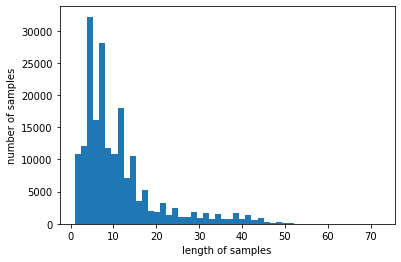

In [25]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [26]:
max_len = 70

X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 모델 설계 및 실행

In [27]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [30]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [32]:
earlystop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
ckpt = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[earlystop, ckpt], batch_size=60, validation_split=0.2)

모델을 통해 test 데이터에 대한 결과 예측 및 csv 변환

In [49]:
loaded_model = load_model('best_model.h5')
prediction = loaded_model.predict_classes(X_test, verbose=0)

prediction = prediction.flatten().tolist()

id = list(range(len(prediction)))

dic = {'Id': id,
       'Predicted': prediction}

df = pd.DataFrame(dic)
df.to_csv('sample.csv', sep=',', index = False)